# Permutation Flow-Shop Scheduling Problem

This is a variant of the Flow-shop scheduling problem (FSSP) in which the sequence of jobs is the same in every machine and there are assembly operations with arbitrary machine precedences.

$$
 \begin{align}
     \text{min} \quad & C_{\text{max}} \\
     \text{s.t.} \quad & h_{i,k} + \sum_{j \in J} p_{j,i} x_{j,k} \leq h_{j,k}
         & \forall ~ (i,j) \in E; k \in K\\
     & h_{m,k} + \sum_{j \in J} p_{j,m} x_{j,k} \leq h_{m,k+1}
         & \forall ~ m \in M; k \in K \setminus \{|K|\}\\
     & \sum_{j \in J} x_{j,k} = 1
         & \forall ~ k \in K\\
     & \sum_{k \in K} x_{j,k} = 1
         & \forall ~ j \in J\\
     & h_{m,|K|} + \sum_{j \in J} p_{j,m} x_{j,|K|} \leq C_{\text{max}}
         & \forall ~ m \in M\\
     & h_{m,k} \geq 0 & \forall ~ m \in M; k \in K\\
     & x_{j,k} \in \{0, 1\} & \forall ~ j \in J; k \in K\\
 \end{align}
 $$

Where $E$ represents the set of directed edges $(i,j)$ indicating that machine $i$ must precede machine $j$ in the processing sequence.

You can compare this implementation to MILP solvers at the [end of the notebook](#bonus---milp-model).

In [ ]:
import gc
import json
import os
import time
from dataclasses import dataclass

from bnbprob.pafssp import CallbackBnB, PermFlowShop, plot_gantt
from bnbprob.pafssp.cython.problem import PermFlowShop2MHalf
from bnbprob.pafssp.instances import AssemblyFlowShopInstance
from bnbpy import configure_logfile

In [3]:
configure_logfile("pafssp-experiments.log", mode="w")

In [4]:
gc.disable()

In [5]:
class WSFlowShop(PermFlowShop2MHalf):
    def warmstart(self):
        jobs = self.sequence
        p = jobs[0].p
        m = len(p)
        n = len(jobs)
        return super().randomized_heur(n * n / m, 42)

In [6]:
@dataclass
class Experiment:
    name: str
    warmstart: int
    lb1_start: int
    lb5_start: int
    incumbent: int
    lower_bound: int
    execution_time: float
    gap: float
    nodes: int
    sequence: list[int]


def run_experiment(
    name: str, instance: AssemblyFlowShopInstance, timelimit: int = 30
) -> Experiment:
    # Initialization
    problem = WSFlowShop.from_p(instance.p, edges=instance.edges)
    bnb = CallbackBnB(rtol=0.0001, save_tree=False)
    # Lower bounds and warmstart
    lb1_start = problem.calc_lb_1m()
    lb5_start = problem.calc_lb_2m()
    warmstart = problem.warmstart().calc_lb_1m()
    # Solve
    start_time = time.time()
    sol = bnb.solve(problem, maxiter=100_000_000, timelimit=timelimit)
    execution_time = time.time() - start_time
    # Results
    sequence_jobs = sol.problem.sequence
    sequence = [job.j for job in sequence_jobs] if sequence_jobs else []
    experiment = Experiment(
        name,
        warmstart,
        lb1_start,
        lb5_start,
        bnb.ub,
        bnb.lb,
        execution_time,
        bnb.gap,
        bnb.explored,
        sequence,
    )
    gc.collect()
    time.sleep(0.2)
    return experiment

## DPm -> Fm || Cmax

In [ ]:
experiments = list[Experiment]()

input_path = './../data/pafssp/dpm'
# Scan directory for all instances
for file in os.listdir(input_path):
    if not file.endswith('.json'):
        continue
    name = file[:-5]
    idx = int(name[4:7])
    with open(os.path.join(input_path, file), 'r', encoding='utf8') as f:
        data = json.load(f)
    instance = AssemblyFlowShopInstance(data["p"], data["edges"])
    experiment = run_experiment(name, instance, timelimit=3600 * 2)
    experiments.append(experiment)
    print(experiment)

Experiment(name='dpm-037-50-5x6', warmstart=3091, lb1_start=3091, lb5_start=3091, incumbent=3091.0, lower_bound=3091.0, execution_time=3.6512134075164795, gap=0.0, nodes=0, sequence=[45, 46, 28, 34, 17, 24, 40, 21, 27, 20, 22, 16, 47, 4, 36, 15, 2, 5, 29, 12, 41, 0, 8, 48, 44, 23, 35, 33, 49, 3, 38, 18, 25, 11, 10, 42, 31, 13, 32, 37, 30, 7, 1, 9, 39, 26, 43, 6, 19, 14])
Experiment(name='dpm-052-50-5x14', warmstart=3720, lb1_start=3283, lb5_start=3355, incumbent=3717.0, lower_bound=3346.0, execution_time=7200.001773118973, gap=0.09981167608286252, nodes=29336837, sequence=[25, 20, 11, 37, 19, 3, 49, 10, 31, 30, 4, 16, 17, 46, 2, 18, 9, 42, 0, 1, 34, 6, 35, 48, 13, 33, 43, 15, 28, 24, 7, 23, 44, 32, 41, 21, 27, 29, 26, 40, 36, 8, 5, 45, 39, 47, 38, 22, 12, 14])
Experiment(name='dpm-040-50-5x6', warmstart=2918, lb1_start=2898, lb5_start=2906, incumbent=2906.0, lower_bound=2906.0, execution_time=4.758050203323364, gap=0.0, nodes=5405, sequence=[11, 18, 9, 42, 39, 47, 40, 13, 5, 43, 46, 41

In [6]:
experiments = list[Experiment]()

input_path = './../data/pafssp/dpm'
# Scan directory for all instances
for file in os.listdir(input_path):
    if not file.endswith('.json'):
        continue
    name = file[:-5]
    idx = int(name[4:7])
    # if not (11 <= idx <= 20):
    #     continue
    with open(os.path.join(input_path, file), 'r', encoding='utf8') as f:
        data = json.load(f)
    instance = AssemblyFlowShopInstance(data["p"], data["edges"])
    experiment = run_experiment(name, instance, timelimit=int(3600 * 1.5))
    experiments.append(experiment)
    print(experiment)


Experiment(name='dpm-037-50-5x6', warmstart=3130, lb1_start=3091, lb5_start=3091, incumbent=3091.0, lower_bound=3091.0, execution_time=0.4991180896759033, gap=0.0, nodes=22, sequence=[6, 29, 22, 8, 0, 49, 24, 40, 21, 31, 41, 47, 46, 34, 17, 27, 20, 4, 28, 36, 15, 2, 5, 48, 44, 35, 38, 25, 11, 13, 16, 37, 30, 1, 23, 10, 9, 33, 39, 42, 18, 45, 26, 7, 32, 12, 43, 3, 19, 14])
Experiment(name='dpm-052-50-5x14', warmstart=3964, lb1_start=3283, lb5_start=3355, incumbent=3795.0, lower_bound=3391.0, execution_time=5400.000995159149, gap=0.10645586297760211, nodes=15965465, sequence=[11, 49, 10, 47, 9, 42, 13, 38, 28, 4, 25, 8, 16, 17, 30, 19, 23, 44, 3, 34, 39, 29, 46, 36, 0, 31, 18, 27, 37, 1, 7, 35, 41, 21, 14, 12, 15, 24, 48, 40, 2, 45, 20, 33, 6, 5, 22, 43, 26, 32])
Experiment(name='dpm-040-50-5x6', warmstart=3048, lb1_start=2898, lb5_start=2917, incumbent=2906.0, lower_bound=2906.0, execution_time=16.81700372695923, gap=0.0, nodes=149517, sequence=[18, 9, 43, 46, 13, 40, 19, 41, 37, 32, 35

In [7]:
from dataclasses import asdict

import pandas as pd

df = pd.DataFrame([asdict(e) for e in experiments])
df.to_csv('pafssp-experiments.csv', index=False)

In [8]:
experiments = list[Experiment]()

input_path = './../data/pafssp/d2f'
# Scan directory for all instances
for file in os.listdir(input_path):
    if not file.endswith('.json'):
        continue
    name = file[:-5]
    idx = int(name[4:7])
    # if not (11 <= idx <= 20):
    #     continue
    with open(os.path.join(input_path, file), 'r', encoding='utf8') as f:
        data = json.load(f)
    instance = AssemblyFlowShopInstance(data["p"], data["edges"])
    experiment = run_experiment(name, instance, timelimit=int(3600 * 1.5))
    experiments.append(experiment)
    print(experiment)

Experiment(name='d2f-007-20-7x7', warmstart=1556, lb1_start=1373, lb5_start=1406, incumbent=1457.0, lower_bound=1457.0, execution_time=7.368344068527222, gap=0.0, nodes=127645, sequence=[7, 3, 18, 13, 15, 0, 9, 5, 10, 2, 19, 17, 1, 12, 8, 14, 4, 6, 16, 11])
Experiment(name='d2f-038-50-7x7', warmstart=3196, lb1_start=3073, lb5_start=3092, incumbent=3110.0, lower_bound=3110.0, execution_time=1.7014977931976318, gap=0.0, nodes=5076, sequence=[30, 5, 13, 32, 9, 43, 20, 10, 35, 49, 11, 34, 12, 26, 47, 24, 44, 19, 37, 36, 16, 7, 25, 8, 14, 33, 41, 27, 15, 3, 1, 48, 2, 38, 28, 46, 22, 4, 39, 42, 31, 29, 40, 21, 17, 45, 6, 18, 23, 0])
Experiment(name='d2f-015-20-10x10', warmstart=1662, lb1_start=1411, lb5_start=1481, incumbent=1604.0, lower_bound=1604.0, execution_time=66.50151252746582, gap=0.0, nodes=890761, sequence=[18, 4, 10, 17, 3, 0, 9, 2, 6, 5, 19, 13, 15, 11, 8, 12, 1, 16, 7, 14])
Experiment(name='d2f-016-20-10x10', warmstart=1717, lb1_start=1511, lb5_start=1556, incumbent=1618.0, low

In [9]:
from dataclasses import asdict

import pandas as pd

df = pd.DataFrame([asdict(e) for e in experiments])
df.to_csv('pafssp-experiments-d2f.csv', index=False)

In [11]:
experiments = list[Experiment]()

input_path = './../data/pafssp/dpm'
# Scan directory for all instances
for file in os.listdir(input_path):
    if not file.endswith('.json'):
        continue
    name = file[:-5]
    idx = int(name[4:7])
    if not (41 <= idx <= 50):
        continue
    with open(os.path.join(input_path, file), 'r', encoding='utf8') as f:
        data = json.load(f)
    instance = AssemblyFlowShopInstance(data["p"], data["edges"])
    experiment = run_experiment(name, instance, timelimit=3600)
    experiments.append(experiment)
    print(experiment)

Experiment(name='dpm-041-50-5x9', warmstart=3495, lb1_start=3424, lb5_start=3424, incumbent=3424.0, lower_bound=3424.0, execution_time=9.054025173187256, gap=0.0, nodes=30751, sequence=[46, 19, 29, 30, 7, 1, 13, 21, 38, 31, 25, 15, 36, 12, 45, 5, 32, 33, 42, 14, 34, 18, 6, 2, 41, 27, 48, 0, 11, 10, 43, 39, 17, 23, 49, 20, 37, 22, 28, 40, 24, 4, 47, 26, 9, 8, 44, 16, 35, 3])
Experiment(name='dpm-042-50-5x9', warmstart=3229, lb1_start=2920, lb5_start=2989, incumbent=3037.0, lower_bound=3037.0, execution_time=2914.4309010505676, gap=0.0, nodes=17035265, sequence=[40, 10, 24, 4, 20, 16, 18, 38, 46, 34, 19, 43, 11, 8, 39, 2, 25, 35, 32, 9, 45, 30, 37, 12, 48, 28, 3, 14, 44, 29, 22, 1, 49, 0, 7, 5, 42, 27, 36, 47, 6, 21, 13, 23, 26, 41, 17, 15, 31, 33])
Experiment(name='dpm-043-50-5x9', warmstart=3139, lb1_start=3066, lb5_start=3066, incumbent=3080.0, lower_bound=3080.0, execution_time=168.6261157989502, gap=0.0, nodes=1045306, sequence=[0, 49, 10, 17, 7, 38, 40, 25, 37, 34, 29, 14, 30, 4, 1

In [42]:
experiment

Experiment(name='dpm-20-3x6-023', warmstart=1601, lb1_start=1424, lb5_start=1449, incumbent=1500.0, lower_bound=1500.0, execution_time=0.6019561290740967, gap=0.0, nodes=12277, sequence=[10, 15, 12, 14, 17, 8, 18, 0, 16, 3, 11, 9, 13, 7, 6, 2, 5, 1, 4, 19])

In [27]:
problem = PermFlowShop.from_p(instance.p, edges=instance.edges)
bnb = CallbackBnB(eval_node="in", rtol=0.0001, save_tree=False)

In [28]:
print(problem.warmstart().calc_lb_1m())
sol = bnb.solve(problem, maxiter=10_000_000, timelimit=30)
print(sol)

1721
Status: OPTIMAL | Cost: 1672.0 | LB: 1672.0


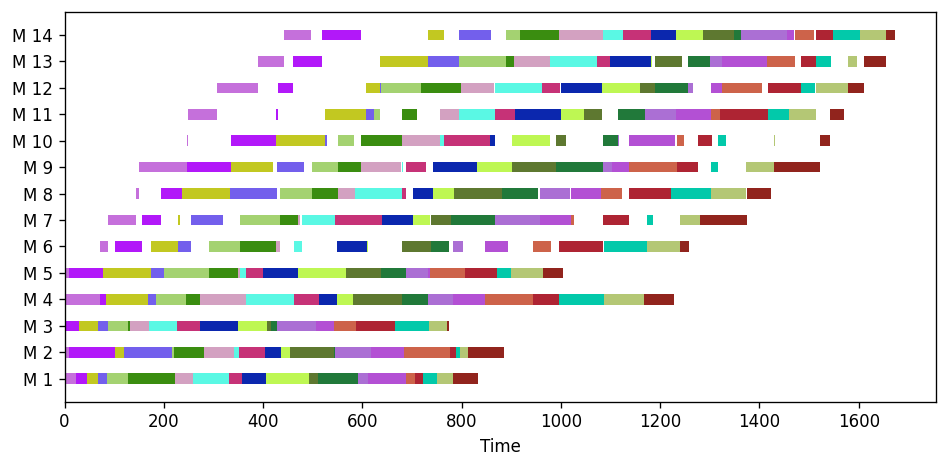

In [23]:
plot_gantt(sol.problem.sequence, dpi=120, seed=42, figsize=[8, 4])

## Parallel Semilines Layout

In [12]:
with open(
    './../data/pafssp/d2f/2f-20-10x10-022.json', 'r', encoding='utf8'
) as f:
    data = json.load(f)


instance = AssemblyFlowShopInstance(data["p"], data["edges"])

In [16]:
problem = PermFlowShop.from_p(instance.p, edges=instance.edges)
bnb = CallbackBnB(eval_node="in", rtol=0.0001, save_tree=False)

In [17]:
sol = bnb.solve(problem, maxiter=10_000_000, timelimit=30)
print(sol)

Status: OPTIMAL | Cost: 1703.0 | LB: 1703.0


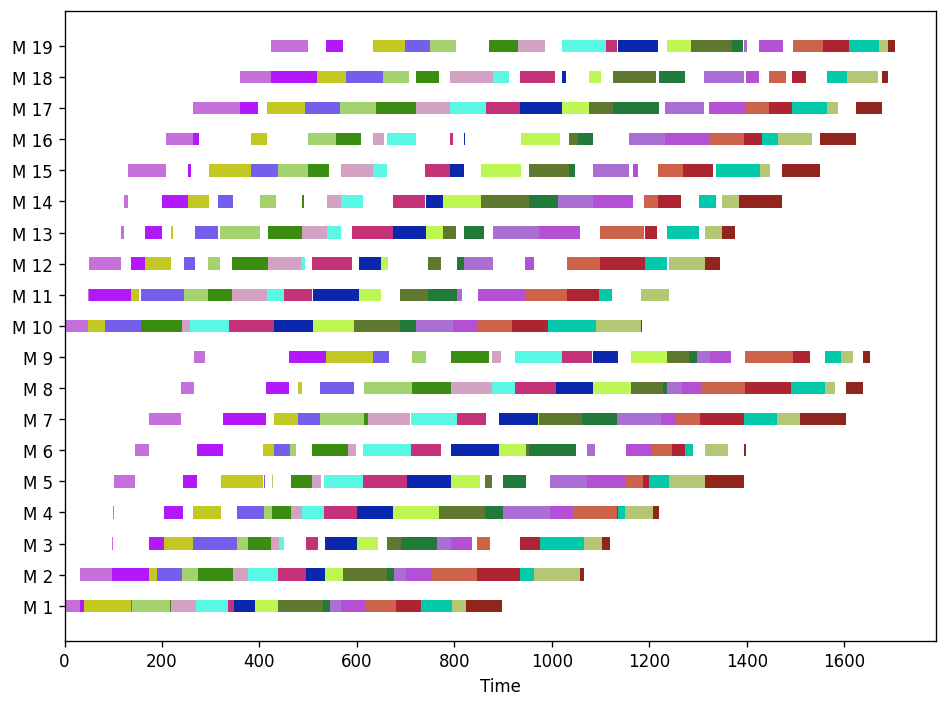

In [19]:
plot_gantt(sol.problem.sequence, dpi=120, seed=42, figsize=[8, 6])

In this implmentation lower bounds are computed by
the max of a single machine and
a two machine relaxations.

The bounds for single and two-machine problems are described
by Potts (1980), also implemented by Ladhari & Haouari (2005),
therein described as 'LB1' and 'LB5'.

If the attribute `constructive` is 'neh', the heuristic
of Nawaz et al. (1983) is adopted, otherwise
the strategy by Palmer (1965).


## References

Ladhari, T., & Haouari, M. (2005). A computational study of
the permutation flow shop problem based on a tight lower bound.
Computers & Operations Research, 32(7), 1831-1847.

Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983).
A heuristic algorithm for the m-machine,
n-job flow-shop sequencing problem.
Omega, 11(1), 91-95.

Potts, C. N. (1980). An adaptive branching rule for the permutation
flow-shop problem. European Journal of Operational Research, 5(1), 19-25.

Palmer, D. S. (1965). Sequencing jobs through a multi-stage process
in the minimum total time—a quick method of obtaining a near optimum.
Journal of the Operational Research Society, 16(1), 101-107

## Bonus - MILP Model

This is the usual Position-based MILP model as an alternative to compare performance.


```python
import pyomo.environ as pyo

from bnbprob.pfssp.mip import positional_model

model = positional_model(p)


# HiGHS
solver = pyo.SolverFactory("appsi_highs")
solver.options["mip_heuristic_effort"] = 0.1
solver.options["time_limit"] = 120
solver.options["log_file"] = "Highs.log"
solver.solve(model, tee=True)

# Gurobi
solver = pyo.SolverFactory("gurobi", solver_io="python")
solver.options["Heuristics"] = 0.2
solver.options["Cuts"] = 2
solver.options["TimeLimit"] = 120
solver.solve(model, tee=True)
```